# Network Motif Analysis for Directed Graphs
# Identification and Z-score calculation for 3-node subgraphs

In [34]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import pandas as pd
from tqdm.notebook import tqdm
from networkx.algorithms import isomorphism

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading a Real-World Directed Network

In [ ]:
def load_arxiv_network():
    """
    Load the arXiv HEP-TH citation network.
    Returns a directed graph.
    """
    # File name
    # edges_file = "Datasets\cit-HepTh.txt\Cit-HepTh.txt"
    edges_file = "Datasets\wiki-Vote.txt\Wiki-Vote.txt"
    # edges_file = "Datasets\email-Eu-core.txt\email-Eu-core.txt"

    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges from the citation file
    with open(edges_file, 'r') as f:
        for line in f:
            # Skip comment lines starting with #
            if line.startswith('#'):
                continue
            # Parse the line
            parts = line.strip().split()
            if len(parts) == 2:
                source, target = parts
                G.add_edge(source, target)
    
    print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

# Load the network
G_original = load_arxiv_network()

def get_subgraph(G, min_size=1000, max_size=4000):
    """
    Extract a connected subgraph with size between min_size and max_size nodes.
    If no component is within the size range, returns a subgraph of the largest component.
    """
    if not nx.is_directed(G):
        components = list(nx.connected_components(G))
    else:
        # For directed graphs, we convert to undirected for finding components
        G_undirected = G.to_undirected()
        components = list(nx.connected_components(G_undirected))
    
    # Sort components by size (largest first)
    components.sort(key=len, reverse=True)
    
    # Take the largest component that has at least min_size nodes
    for component in components:
        if min_size <= len(component) <= max_size:
            subgraph = G.subgraph(component).copy()
            return subgraph
    
    # If no component is in the desired range, take a subset of the largest component
    largest_component = list(components[0])
    if len(largest_component) > max_size:
        # Randomly select max_size nodes from the largest component
        selected_nodes = np.random.choice(largest_component, size=max_size, replace=False)
        subgraph = G.subgraph(selected_nodes).copy()
        
        # Ensure the subgraph is connected (if directed, check if weakly connected)
        if nx.is_directed(G):
            if not nx.is_weakly_connected(subgraph):
                # If not connected, find the largest connected component
                subgraph_undirected = subgraph.to_undirected()
                largest_cc = max(nx.connected_components(subgraph_undirected), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        else:
            if not nx.is_connected(subgraph):
                largest_cc = max(nx.connected_components(subgraph), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        
        return subgraph
    else:
        # Return the largest component if it's smaller than max_size
        return G.subgraph(largest_component).copy()

# Extract a subgraph of reasonable size
G = get_subgraph(G_original, min_size=300, max_size=700)
print(f"Working with a subgraph of {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loaded graph with 7115 nodes and 103689 edges
Working with a subgraph of 312 nodes and 817 edges


## 2. Strategy to Generate All Unique 3-Node Connected Subgraphs

Generated 13 unique 3-node connected directed subgraphs
Selected 5 representative patterns for analysis


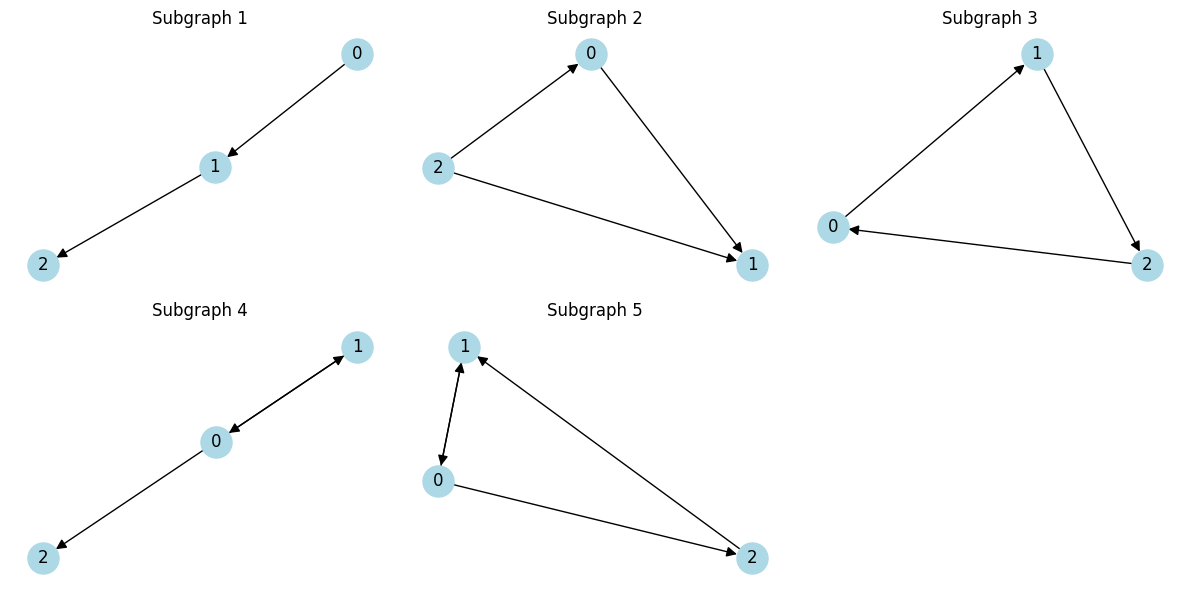

In [ ]:
def generate_all_possible_3node_digraphs(max_patterns=5):
    """
    Generate all possible unique 3-node connected directed subgraphs using NetworkX's
    triadic census, and select up to max_patterns representative patterns.
    
    Parameters:
    -----------
    max_patterns : int
        Maximum number of subgraph patterns to analyze
    
    Returns:
    --------
    list of nx.DiGraph
        List of selected unique 3-node connected directed graphs
    dict
        Mapping from graph ID to its adjacency matrix representation
    """
    # Define the 13 connected triad types
    connected_triad_types = ["021C", "021D", "021U", "111D", "111U",
                            "030T", "030C", "201", "120D", "120U", 
                            "120C", "210", "300"]
    
    # Create a dictionary to store generated triads
    triads = {}
    
    # Generate each type of triad
    for triad_type in connected_triad_types:
        # Create a graph for this triad type
        G = create_triad_by_type(triad_type)
        if G is not None:
            # Store the graph keyed by its triad type
            triads[triad_type] = G
    
    # Sort triads by complexity (edge count, then reciprocity)
    sorted_triads = sorted(triads.items(), 
                          key=lambda x: (nx.number_of_edges(x[1]), nx.reciprocity(x[1])))
    
    # Select representative patterns
    selected_graphs = []
    if len(sorted_triads) <= max_patterns:
        selected_graphs = [g for _, g in sorted_triads]
    else:
        # Select graphs distributed across the complexity spectrum
        step = max(1, len(sorted_triads) // max_patterns)
        indices = list(range(0, len(sorted_triads), step))[:max_patterns]
        # If we don't have enough patterns, add more from the middle
        while len(indices) < max_patterns and len(indices) < len(sorted_triads):
            remaining = [i for i in range(len(sorted_triads)) if i not in indices]
            if remaining:
                indices.append(remaining[len(remaining)//2])
                indices.sort()
            else:
                break
        selected_graphs = [sorted_triads[i][1] for i in indices]
    
    # Assign IDs to the selected graphs
    graph_ids = {}
    for i, G in enumerate(selected_graphs):
        adj_matrix = tuple(map(tuple, nx.to_numpy_array(G)))
        graph_ids[i] = adj_matrix
    
    print(f"Generated {len(triads)} unique 3-node connected directed subgraphs")
    print(f"Selected {len(selected_graphs)} representative patterns for analysis")
    return selected_graphs, graph_ids

def create_triad_by_type(triad_type):
    """
    Create a directed graph representing a specific triad type.
    
    Parameters:
    -----------
    triad_type : str
        The Davis and Leinhardt triad type (e.g., "300", "021C")
    
    Returns:
    --------
    nx.DiGraph
        A directed graph representing the specified triad type
    """
    # Create a new directed graph with three nodes
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    
    # Define the edge sets for each triad type
    # Format: {triad_type: [(from_node, to_node), ...]}
    triad_edges = {
        "300": [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)],  # Complete with all reciprocal edges
        "210": [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2)],  # Missing one edge to be complete
        "201": [(0, 1), (1, 0), (0, 2), (2, 0)],  # Two mutual dyads
        "120D": [(0, 1), (1, 0), (0, 2), (1, 2)],  # Two reciprocal edges, one directed
        "120U": [(0, 1), (1, 0), (0, 2), (2, 1)],  # Two reciprocal edges, one directed (different)
        "120C": [(0, 1), (1, 0), (1, 2), (2, 1)],  # Two reciprocal edges, one directed (different)
        "111D": [(0, 1), (1, 0), (1, 2)],  # One reciprocal edge, one directed
        "111U": [(0, 1), (1, 0), (0, 2)],  # One reciprocal edge, one directed (different)
        "030T": [(0, 1), (1, 2), (0, 2)],  # Transitive triad
        "030C": [(0, 1), (1, 2), (2, 0)],  # Cyclic triad
        "021D": [(0, 1), (0, 2), (1, 2)],  # Two directed edges, outward
        "021U": [(0, 1), (2, 0), (2, 1)],  # Two directed edges, inward
        "021C": [(0, 1), (1, 2)]  # Two directed edges, path
    }
    
    if triad_type in triad_edges:
        G.add_edges_from(triad_edges[triad_type])
        return G
    else:
        print(f"Warning: Unknown triad type {triad_type}")
        return None

def visualize_subgraphs(subgraphs, ncols=4, figsize=(15, 20)):
    """
    Visualize the subgraphs in a grid.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of subgraphs to visualize
    ncols : int
        Number of columns in the grid
    figsize : tuple
        Figure size
    """
    nrows = int(np.ceil(len(subgraphs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, G in enumerate(subgraphs):
        if i < len(axes):
            ax = axes[i]
            ax.set_title(f"Subgraph {i+1}")
            pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout
            nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', 
                    node_size=500, arrowsize=15, arrows=True)
        else:
            print(f"Warning: Not enough axes for all subgraphs")
            break
    
    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("unique_3node_subgraphs.png", dpi=300)
    plt.show()

# Generate representative 3-node connected directed subgraphs
unique_subgraphs, graph_ids = generate_all_possible_3node_digraphs(max_patterns=5)

# Visualize the unique subgraphs
visualize_subgraphs(unique_subgraphs, ncols=3, figsize=(12, 6))

## 3. Identifying Subgraph Patterns in the Real Network

In [39]:
def count_subgraph_occurrences(G, unique_subgraphs):
    """
    Count occurrences of each unique subgraph pattern in the graph
    using NetworkX's triadic census for efficiency.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The graph to analyze
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    max_samples : int, optional
        Maximum number of triads to analyze (not used with triadic census)
    
    Returns:
    --------
    dict
        Mapping from pattern ID to count
    """
    # Get the triadic census
    census = nx.triadic_census(G)
    
    # Connected triad types
    connected_types = ["021C", "021D", "021U", "111D", "111U",
                       "030T", "030C", "201", "120D", "120U", "120C", "210", "300"]
    
    # Create a mapping from triad types to pattern IDs
    pattern_mapping = {}
    for pattern_id, pattern in enumerate(unique_subgraphs):
        for triad_type in connected_types:
            reference_triad = create_triad_by_type(triad_type)
            if reference_triad is not None:
                gm = isomorphism.DiGraphMatcher(pattern, reference_triad)
                if gm.is_isomorphic():
                    pattern_mapping[triad_type] = pattern_id
                    break
    
    # Count occurrences based on the mapping
    pattern_counts = defaultdict(int)
    for triad_type, count in census.items():
        if triad_type in pattern_mapping:
            pattern_id = pattern_mapping[triad_type]
            pattern_counts[pattern_id] += count
    
    return pattern_counts

real_counts = count_subgraph_occurrences(G, unique_subgraphs)
print(f"Found {sum(real_counts.values())} connected 3-node subgraphs in the real network")
print(f"Distributed across {len(real_counts)} unique patterns")
print("Pattern ID : Count")
for pattern_id, count in real_counts.items():
    print(f"{pattern_id} : {count}")

Found 4783 connected 3-node subgraphs in the real network
Distributed across 5 unique patterns
Pattern ID : Count
1 : 2984
0 : 1582
3 : 169
2 : 5
4 : 43


## 4. Generating Random Networks and Computing Z-Scores

In [41]:
def generate_random_network(G, model='configuration', num_swaps=10):
    """
    Generate a random network that preserves the degree sequence of the original network.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    model : str
        The randomization model to use ('configuration' or 'edge_swap')
    num_swaps : int
        Number of edge swaps per edge (for 'edge_swap' model)
    
    Returns:
    --------
    nx.DiGraph
        The randomized graph
    """
    if model == 'configuration':
        # Get in and out degree sequences
        in_degrees = [d for n, d in G.in_degree()]
        out_degrees = [d for n, d in G.out_degree()]
        
        # Generate random graph with the same degree sequence
        G_random = nx.directed_configuration_model(
            in_degrees, 
            out_degrees, 
            seed=np.random.randint(0, 10000)
        )
        
        # Remove parallel edges and self-loops
        G_random = nx.DiGraph(G_random)
        
    elif model == 'edge_swap':
        # Create a copy of the original graph
        G_random = G.copy()
        
        # Perform edge swaps
        edges = list(G_random.edges())
        n_swaps = int(num_swaps * len(edges))
        
        swapped = 0
        attempts = 0
        max_attempts = n_swaps * 10  # Limit attempts to avoid infinite loops
        
        while swapped < n_swaps and attempts < max_attempts:
            # Randomly select two edges
            idx1, idx2 = np.random.choice(len(edges), 2, replace=False)
            edge1 = edges[idx1]
            edge2 = edges[idx2]
            
            # Extract the source and target nodes
            u1, v1 = edge1
            u2, v2 = edge2
            
            # Check if the new edges already exist or would create self-loops
            if (u1 != v2 and u2 != v1 
                and not G_random.has_edge(u1, v2) 
                and not G_random.has_edge(u2, v1)):
                
                # Remove the original edges
                G_random.remove_edge(u1, v1)
                G_random.remove_edge(u2, v2)
                
                # Add the new edges
                G_random.add_edge(u1, v2)
                G_random.add_edge(u2, v1)
                
                # Update the edges list
                edges[idx1] = (u1, v2)
                edges[idx2] = (u2, v1)
                
                swapped += 1
                
            attempts += 1
    
    else:
        raise ValueError(f"Unknown randomization model: {model}")
    
    return G_random

def compute_z_scores(G, unique_subgraphs, num_random=100, random_model='configuration'):
    """
    Compute Z-scores for each subgraph pattern using an efficient triad census approach.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    num_random : int
        Number of random networks to generate
    random_model : str
        The randomization model to use ('configuration' or 'edge_swap')
    max_samples : int
        Maximum number of triads to sample per graph (not used with triad census)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with Z-scores and related statistics
    """
    # Use triadic census for the real network
    connected_types = ["021C", "021D", "021U", "111D", "111U",
                       "030T", "030C", "201", "120D", "120U", "120C", "210", "300"]
    
    census_real = nx.triadic_census(G)
    # Filter only connected triads
    census_real = {k: v for k, v in census_real.items() if k in connected_types}
    
    # Map triad types to pattern IDs for output consistency
    type_to_pattern_id = {}
    for pattern_id, pattern in enumerate(unique_subgraphs):
        for triad_type in connected_types:
            reference_triad = create_triad_by_type(triad_type)
            if reference_triad is not None:
                gm = isomorphism.DiGraphMatcher(pattern, reference_triad)
                if gm.is_isomorphic():
                    type_to_pattern_id[triad_type] = pattern_id
                    break
    
    # Convert real counts to pattern ID format
    real_counts = defaultdict(int)
    for triad_type, count in census_real.items():
        if triad_type in type_to_pattern_id:
            pattern_id = type_to_pattern_id[triad_type]
            real_counts[pattern_id] += count
    
    # Store counts for each triad type in each random network
    census_random = {k: [] for k in census_real.keys()}
    
    # Generate random networks and count patterns
    for i in tqdm(range(num_random), desc=f"Generating and analyzing {num_random} random networks"):
        if random_model == 'configuration':
            G_random = randomize_directed_configuration_model(G)
        else:  # edge_swap
            G_random = generate_random_network(G, model='edge_swap')
        
        # Get the triadic census for random network
        census_rand = nx.triadic_census(G_random)
        # Store counts for each triad type
        for triad_type in census_random:
            census_random[triad_type].append(census_rand.get(triad_type, 0))
    
    # Compute statistics for each triad type
    stats_random = {}
    for triad_type, counts in census_random.items():
        mean_val = np.mean(counts)
        std_val = np.std(counts, ddof=1)
        stats_random[triad_type] = {"mean": mean_val, "std": std_val}
    
    # Compute Z-scores
    z_scores_by_type = {}
    for triad_type in census_real:
        real_count = census_real[triad_type]
        mean_val = stats_random[triad_type]["mean"]
        std_val = stats_random[triad_type]["std"]
        # Avoid division by zero
        z = 0 if std_val == 0 else (real_count - mean_val) / std_val
        z_scores_by_type[triad_type] = z
    
    # Convert to pattern-based format for output
    data = []
    for pattern_id in range(len(unique_subgraphs)):
        # Find which triad type corresponds to this pattern
        matching_types = [t for t, pid in type_to_pattern_id.items() if pid == pattern_id]
        
        if matching_types:
            # Sum stats across all matching types (usually just one)
            real_count = sum(census_real.get(t, 0) for t in matching_types)
            rand_mean = sum(stats_random[t]["mean"] for t in matching_types if t in stats_random)
            
            # For std, we need to be more careful - use the first matching type's std as approximation
            # This is a simplification as properly combining std values is more complex
            triad_type = matching_types[0]
            rand_std = stats_random[triad_type]["std"] if triad_type in stats_random else 0
            
            # Use the Z-score from the matching type
            z_score = z_scores_by_type[triad_type] if triad_type in z_scores_by_type else 0
        else:
            # No matching triad type found for this pattern
            real_count = 0
            rand_mean = 0
            rand_std = 0
            z_score = 0
        
        # Store data
        data.append({
            'Pattern ID': pattern_id,
            'Real Count': real_count,
            'Random Mean': rand_mean,
            'Random Std': rand_std,
            'Z-Score': z_score
        })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Sort by Z-score (absolute value, descending)
    df = df.sort_values(by='Z-Score', key=abs, ascending=False)
    
    return df

def randomize_directed_configuration_model(G):
    """
    Generate a random directed graph that preserves the in and out degree sequences.
    Handles edge weights by sampling from the original weights.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    
    Returns:
    --------
    nx.DiGraph
        A randomized version of the graph with same degree sequence
    """
    # Get degree sequences
    in_seq = [d for _, d in G.in_degree()]
    out_seq = [d for _, d in G.out_degree()]
    
    # Generate multi-graph first (allows parallel edges during construction)
    multiG = nx.directed_configuration_model(
        in_seq, 
        out_seq, 
        create_using=nx.MultiDiGraph(), 
        seed=np.random.randint(0, 10000)
    )
    
    # Convert to simple DiGraph (removes parallel edges)
    G_rand = nx.DiGraph(multiG)
    
    # Remove self-loops if any
    G_rand.remove_edges_from(list(nx.selfloop_edges(G_rand)))
    
    # Check if original graph has edge attributes to preserve
    if G.number_of_edges() > 0 and "weight" in next(iter(G.edges(data=True)))[-1]:
        # Sample weights from original graph
        original_weights = [data["weight"] for _, _, data in G.edges(data=True)]
        for u, v in G_rand.edges():
            G_rand[u][v]["weight"] = np.random.choice(original_weights)
    
    return G_rand

z_scores_df = compute_z_scores(G, unique_subgraphs, num_random=10, random_model='configuration')
print(z_scores_df.head(10))


Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

   Pattern ID  Real Count  Random Mean  Random Std    Z-Score
4           4          43          4.1    3.665151  10.613478
0           0        1582       2082.9  103.674115  -4.831486
3           3         169         59.6   23.912805   4.574955
2           2           5          7.9    2.024846  -1.432208
1           1        2984       3007.7   95.172417  -0.249022


## 5. Identifying Motifs and Anti-Motifs


Pattern Motif Classification Based on Z-Scores:
Pattern ID : Classification                 : Z-score
------------------------------------------------------------
      0.0 : Anti-motif (under-represented) : -4.83
      1.0 : Not significant                : -0.25
      2.0 : Not significant                : -1.43
      3.0 : Motif (over-represented)       : 4.57
      4.0 : Motif (over-represented)       : 10.61


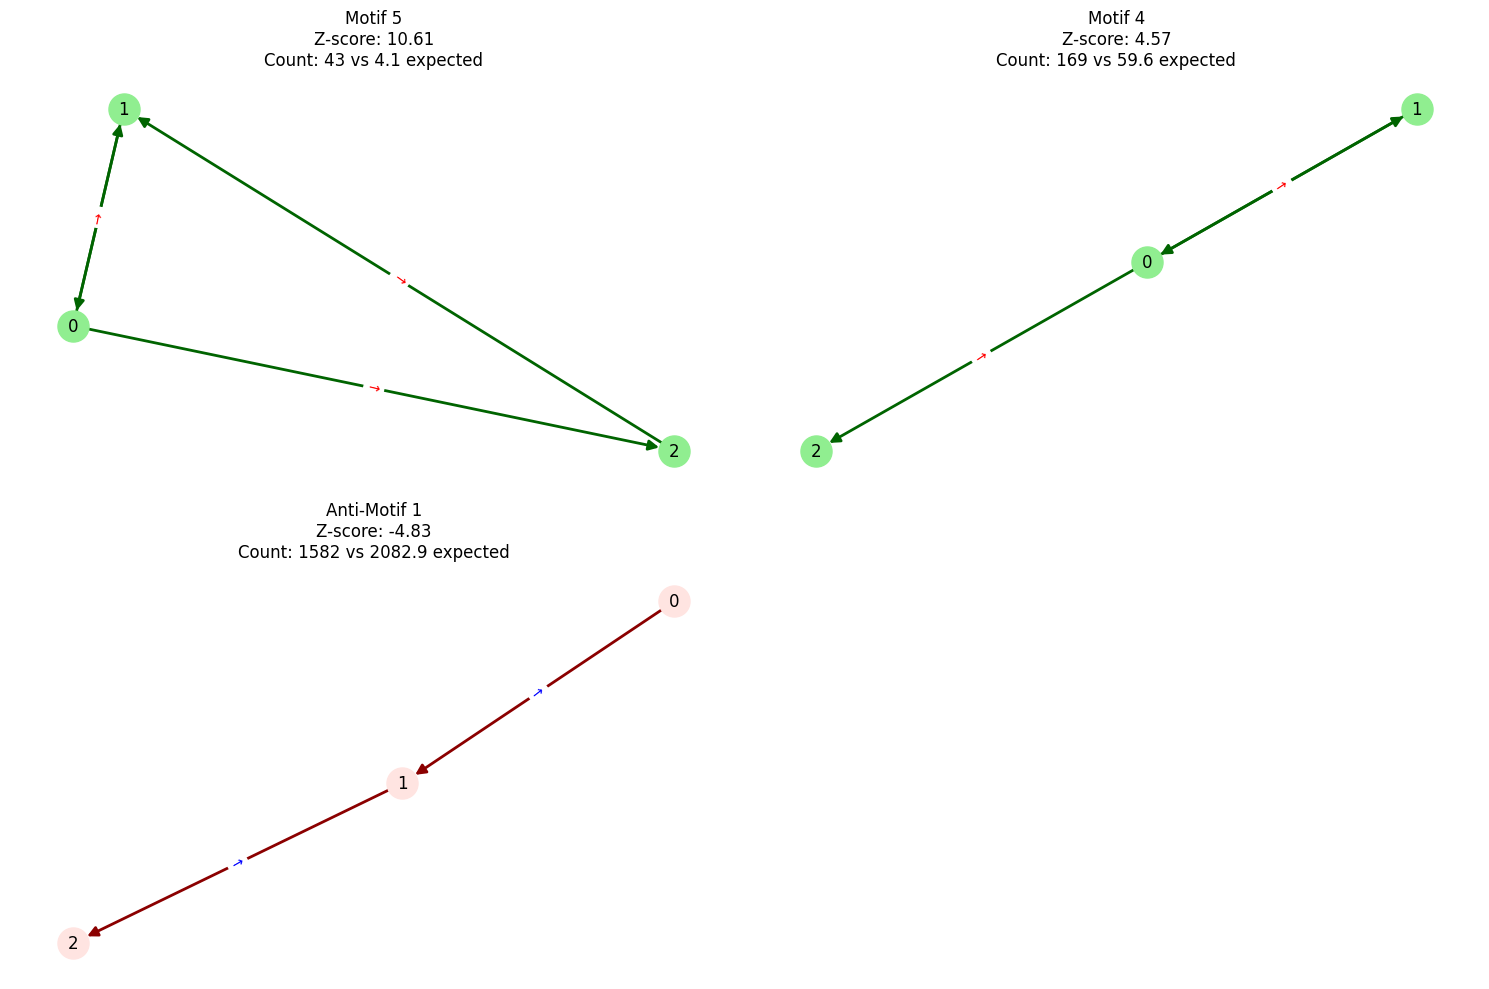


=== Structural Analysis of Motifs and Anti-motifs ===

Motif Properties:

Motif 5:
  - Edges: 4
  - Reciprocity: 0.50
  - Transitivity: 0.50
  - Type: Partially reciprocal

Motif 4:
  - Edges: 3
  - Reciprocity: 0.67
  - Transitivity: 0.00
  - Type: Partially reciprocal

Anti-motif Properties:

Anti-motif 1:
  - Edges: 2
  - Reciprocity: 0.00
  - Transitivity: 0.00


In [44]:
def identify_and_analyze_motifs(G, unique_subgraphs, z_scores_df=None, threshold=2.0, visualize=True):
    """
    Identify motifs and anti-motifs based on Z-scores, with comprehensive analysis.
    Works with either DataFrame-based z-scores or dictionary-based z-scores.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The analyzed graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    z_scores_df : pandas.DataFrame, optional
        DataFrame with Z-scores (if using DataFrame approach)
    threshold : float
        Z-score threshold for significance
    visualize : bool
        Whether to visualize the motifs and anti-motifs
    
    Returns:
    --------
    tuple
        Lists of motif IDs and anti-motif IDs, and classification dictionary
    """
    # Check which type of z-scores we're working with
    if z_scores_df is not None:
        # DataFrame approach
        motifs = z_scores_df[z_scores_df['Z-Score'] > threshold]['Pattern ID'].tolist()
        anti_motifs = z_scores_df[z_scores_df['Z-Score'] < -threshold]['Pattern ID'].tolist()
        
        # Create classification dictionary for reporting
        classification_dict = {}
        for _, row in z_scores_df.iterrows():
            pattern_id = row['Pattern ID']
            z_score = row['Z-Score']
            if z_score > threshold:
                status = "Motif (over-represented)"
            elif z_score < -threshold:
                status = "Anti-motif (under-represented)"
            else:
                status = "Not significant"
            classification_dict[pattern_id] = {"status": status, "z_score": z_score}
        
        # Print classification summary
        print("\nPattern Motif Classification Based on Z-Scores:")
        print("Pattern ID : Classification                 : Z-score")
        print("-" * 60)
        for pattern_id in sorted(classification_dict.keys()):
            info = classification_dict[pattern_id]
            print(f"{pattern_id:9} : {info['status']:30} : {info['z_score']:.2f}")
    
    else:
        # Dictionary approach - we need to create the classification
        # Assume we have a z_scores dictionary mapping triad types to Z-scores
        # This requires the mapping from pattern IDs to triad types
        # For now, we'll assume this is not the primary use case
        raise ValueError("Dictionary-based z_scores not supported in this implementation")
    
    # If we should visualize the motifs
    if visualize and z_scores_df is not None:
        visualize_motifs(unique_subgraphs, motifs, anti_motifs, z_scores_df)
    
    # Perform additional analysis on the motifs
    if len(motifs) > 0 or len(anti_motifs) > 0:
        analyze_motif_properties(unique_subgraphs, motifs, anti_motifs)
    
    return motifs, anti_motifs, classification_dict


def analyze_motif_properties(subgraphs, motifs, anti_motifs):
    """
    Analyze properties of motifs and anti-motifs to provide structural insights.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of all unique subgraphs
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    """
    print("\n=== Structural Analysis of Motifs and Anti-motifs ===")
    
    # Analyze motifs
    if motifs:
        print("\nMotif Properties:")
        for pattern_id in motifs:
            G_sub = subgraphs[pattern_id]
            reciprocity = nx.reciprocity(G_sub)
            transitivity = nx.transitivity(G_sub)
            edge_count = G_sub.number_of_edges()
            
            print(f"\nMotif {pattern_id+1}:")
            print(f"  - Edges: {edge_count}")
            print(f"  - Reciprocity: {reciprocity:.2f}")
            print(f"  - Transitivity: {transitivity:.2f}")
            
            # Classify the motif
            if reciprocity == 1:
                motif_type = "Fully connected (clique-like)"
            elif transitivity == 1:
                motif_type = "Transitive (hierarchical)"
            elif reciprocity > 0:
                motif_type = "Partially reciprocal"
            elif nx.is_directed_acyclic_graph(G_sub):
                motif_type = "Directed acyclic (hierarchical)"
            elif edge_count == 3 and nx.is_strongly_connected(G_sub):
                motif_type = "Cycle (feedback loop)"
            elif edge_count == 2:
                motif_type = "Path (linear chain)"
            else:
                motif_type = "Complex structure"
            
            print(f"  - Type: {motif_type}")
    else:
        print("\nNo significant motifs detected.")
    
    # Analyze anti-motifs
    if anti_motifs:
        print("\nAnti-motif Properties:")
        for pattern_id in anti_motifs:
            G_sub = subgraphs[pattern_id]
            reciprocity = nx.reciprocity(G_sub)
            transitivity = nx.transitivity(G_sub)
            edge_count = G_sub.number_of_edges()
            
            print(f"\nAnti-motif {pattern_id+1}:")
            print(f"  - Edges: {edge_count}")
            print(f"  - Reciprocity: {reciprocity:.2f}")
            print(f"  - Transitivity: {transitivity:.2f}")
    else:
        print("\nNo significant anti-motifs detected.")

def visualize_motifs(subgraphs, motifs, anti_motifs, z_scores_df, figsize=(15, 10)):
    """
    Visualize motifs and anti-motifs with enhanced layout and information.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of all unique subgraphs
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    figsize : tuple
        Figure size
    """
    # Count motifs and anti-motifs
    n_motifs = len(motifs)
    n_anti_motifs = len(anti_motifs)
    
    # Check if there's anything to visualize
    if n_motifs == 0 and n_anti_motifs == 0:
        print("No motifs or anti-motifs found to visualize")
        return
    
    # Determine layout
    if n_motifs > 0 and n_anti_motifs > 0:
        nrows = 2
        ncols = max(n_motifs, n_anti_motifs)
    elif n_motifs > 0:
        nrows = 1
        ncols = n_motifs
    else:  # Only anti-motifs
        nrows = 1
        ncols = n_anti_motifs
    
    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)  # squeeze=False ensures axes is always 2D
    
    # Plot motifs
    if n_motifs > 0:
        row = 0
        for col, pattern_id in enumerate(motifs):
            if col < ncols:
                ax = axes[row, col]
                
                # Check if pattern_id exists in z_scores_df
                pattern_data = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]
                if len(pattern_data) == 0:
                    print(f"Warning: Pattern ID {pattern_id} not found in z_scores_df")
                    continue
                    
                z_score = pattern_data['Z-Score'].values[0]
                real_count = pattern_data['Real Count'].values[0]
                rand_mean = pattern_data['Random Mean'].values[0]
                
                # Verify that the pattern_id is valid for subgraphs list
                if pattern_id >= len(subgraphs):
                    print(f"Warning: Pattern ID {pattern_id} is out of range for subgraphs list")
                    continue
                
                # Enhanced title with more information
                ax.set_title(
                    f"Motif {pattern_id+1}\nZ-score: {z_score:.2f}\n"
                    f"Count: {real_count} vs {rand_mean:.1f} expected"
                )
                
                # Draw the graph with a nice layout
                G_to_draw = subgraphs[pattern_id]
                if len(G_to_draw.nodes()) > 0:  # Ensure the graph has nodes
                    pos = nx.spring_layout(G_to_draw, seed=42)
                    nx.draw(
                        G_to_draw, pos, 
                        ax=ax, with_labels=True, 
                        node_color='lightgreen', node_size=500, 
                        edge_color='darkgreen', width=2,
                        arrowsize=15, arrows=True
                    )
                    
                    # Add edge labels to show edge directions more clearly
                    edge_labels = {(u, v): "→" for u, v in G_to_draw.edges()}
                    nx.draw_networkx_edge_labels(
                        G_to_draw, pos,
                        edge_labels=edge_labels,
                        font_color='red',
                        ax=ax
                    )
                else:
                    print(f"Warning: Graph for pattern ID {pattern_id} has no nodes")
            else:
                print(f"Warning: Not enough columns for all motifs")
    
    # Plot anti-motifs
    if n_anti_motifs > 0:
        row = 1 if n_motifs > 0 else 0
        for col, pattern_id in enumerate(anti_motifs):
            if col < ncols:
                ax = axes[row, col]
                
                # Check if pattern_id exists in z_scores_df
                pattern_data = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]
                if len(pattern_data) == 0:
                    print(f"Warning: Pattern ID {pattern_id} not found in z_scores_df")
                    continue
                    
                z_score = pattern_data['Z-Score'].values[0]
                real_count = pattern_data['Real Count'].values[0]
                rand_mean = pattern_data['Random Mean'].values[0]
                
                # Verify that the pattern_id is valid for subgraphs list
                if pattern_id >= len(subgraphs):
                    print(f"Warning: Pattern ID {pattern_id} is out of range for subgraphs list")
                    continue
                
                # Enhanced title with more information
                ax.set_title(
                    f"Anti-Motif {pattern_id+1}\nZ-score: {z_score:.2f}\n"
                    f"Count: {real_count} vs {rand_mean:.1f} expected"
                )
                
                # Draw the graph with a nice layout
                G_to_draw = subgraphs[pattern_id]
                if len(G_to_draw.nodes()) > 0:  # Ensure the graph has nodes
                    pos = nx.spring_layout(G_to_draw, seed=42)
                    nx.draw(
                        G_to_draw, pos, 
                        ax=ax, with_labels=True, 
                        node_color='mistyrose', node_size=500, 
                        edge_color='darkred', width=2,
                        arrowsize=15, arrows=True
                    )
                    
                    # Add edge labels to show edge directions more clearly
                    edge_labels = {(u, v): "→" for u, v in G_to_draw.edges()}
                    nx.draw_networkx_edge_labels(
                        G_to_draw, pos,
                        edge_labels=edge_labels,
                        font_color='blue',
                        ax=ax
                    )
                else:
                    print(f"Warning: Graph for pattern ID {pattern_id} has no nodes")
            else:
                print(f"Warning: Not enough columns for all anti-motifs")
    
    # Hide any unused axes
    for i in range(nrows):
        for j in range(ncols):
            if (i == 0 and j >= n_motifs) or (i == 1 and j >= n_anti_motifs):
                axes[i, j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("motifs_and_antimotifs.png", dpi=300)
    plt.show()

motifs, anti_motifs, classification = identify_and_analyze_motifs(
    G, unique_subgraphs, z_scores_df=z_scores_df, threshold=2.0, visualize=True
)

## 6. Interpretation and Analysis of Motifs

In [45]:
def interpret_motifs(subgraphs, z_scores_df, motifs, anti_motifs):
    """
    Provide interpretation of motifs and anti-motifs.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of all unique subgraphs
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    
    Returns:
    --------
    str
        Interpretation text
    """
    # Classify motif types
    motif_types = {}
    for pattern_id in motifs:
        G_sub = subgraphs[pattern_id]
        
        # Compute characteristics
        reciprocity = nx.reciprocity(G_sub)
        transitivity = nx.transitivity(G_sub)
        
        # Classify type
        if reciprocity == 1:  # All edges bidirectional
            motif_type = "Fully connected (clique-like)"
        elif transitivity == 1:  # Perfect transitivity
            motif_type = "Transitive (hierarchical)"
        elif reciprocity > 0:  # Some edges are bidirectional
            motif_type = "Partially reciprocal"
        elif nx.is_directed_acyclic_graph(G_sub):  # DAG
            motif_type = "Directed acyclic (hierarchical)"
        elif (nx.number_of_edges(G_sub) == 3 
              and nx.is_strongly_connected(G_sub)):  # 3 edges & strongly connected => 3-cycle
            motif_type = "Cycle (feedback loop)"
        elif nx.number_of_edges(G_sub) == 2:  # could be a path
            motif_type = "Path (linear chain)"
        else:
            motif_type = "Complex structure"
        
        motif_types[pattern_id] = motif_type
    
    # Prepare interpretation text
    if len(motifs) == 0 and len(anti_motifs) == 0:
        interpretation = """
        No significant motifs or anti-motifs were detected in the network. This suggests that
        the network's local structure can be largely explained by its degree sequence alone,
        without additional organizing principles.
        """
    else:
        interpretation = """
        # Network Motif Analysis Results
        
        ## Motifs (Over-represented Subgraphs)
        """
        if len(motifs) > 0:
            interpretation += "\nThe following subgraph patterns appear significantly more often than expected by chance:\n"
            for pattern_id in motifs:
                z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
                real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
                rand_mean = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
                motif_type = motif_types[pattern_id]
                
                interpretation += f"""
                - **Motif {pattern_id+1}**: Z-score = {z_score:.2f}
                  - Count in real network: {real_count} (vs. {rand_mean:.2f} in random networks)
                  - Type: {motif_type}
                """
        else:
            interpretation += "\nNo significant motifs were detected.\n"
        
        interpretation += """
        
        ## Anti-Motifs (Under-represented Subgraphs)
        """
        if len(anti_motifs) > 0:
            interpretation += "\nThe following subgraph patterns appear significantly less often than expected by chance:\n"
            for pattern_id in anti_motifs:
                z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
                real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
                rand_mean = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
                
                interpretation += f"""
                - **Anti-Motif {pattern_id+1}**: Z-score = {z_score:.2f}
                  - Count in real network: {real_count} (vs. {rand_mean:.2f} in random networks)
                """
        else:
            interpretation += "\nNo significant anti-motifs were detected.\n"
        
        # Example of adding domain-specific comments if we know this is a citation network
        # (Part of the original code references "G_full," so you can adapt that if needed.)
        if hasattr(G, 'name') and "citation" in G.name.lower():
            interpretation += """
            
            ## Structural Interpretation for Citation Network
            
            In citation networks, motifs often reveal characteristic citation patterns:
            
            1. **Hierarchical motifs** (chain-like or tree-like structures) suggest temporal knowledge flow,
               where older papers are cited by newer ones in sequence, reflecting how scientific knowledge builds on prior work.
            
            2. **Reciprocal motifs** (bidirectional edges) might represent contemporaneous papers that cite each other,
               possibly indicating collaborative or competing research groups.
            
            3. **Cyclic motifs** suggest closely related papers, possibly from the same research group or project,
               that form citation loops.
            
            4. **Star motifs** (one paper receiving many citations) might represent review or landmark papers
               that anchor a subfield.
            """
        else:
            interpretation += """
            
            ## Structural Interpretation
            
            Motifs serve as the building blocks of complex networks and reveal fundamental
            organizational principles. For instance:
            
            - **Feed-forward loops** provide multiple paths of regulation or information flow, 
              acting as persistence detectors.
            - **Feedback loops** enable dynamic behaviors like oscillations or memory.
            - **Linear chains** represent hierarchical or sequential processes.
            - **Divergent patterns** indicate broadcasting or control centers.
            - **Convergent patterns** suggest integration or decision points.
            
            Anti-motifs may represent patterns that are structurally or functionally unfavorable
            for the system's purpose.
            """
    
    return interpretation

# Generate the interpretation
motif_interpretation = interpret_motifs(unique_subgraphs, z_scores_df, motifs, anti_motifs)
print(motif_interpretation)


        # Network Motif Analysis Results
        
        ## Motifs (Over-represented Subgraphs)
        
The following subgraph patterns appear significantly more often than expected by chance:

                - **Motif 5**: Z-score = 10.61
                  - Count in real network: 43 (vs. 4.10 in random networks)
                  - Type: Partially reciprocal
                
                - **Motif 4**: Z-score = 4.57
                  - Count in real network: 169 (vs. 59.60 in random networks)
                  - Type: Partially reciprocal
                
        
        ## Anti-Motifs (Under-represented Subgraphs)
        
The following subgraph patterns appear significantly less often than expected by chance:

                - **Anti-Motif 1**: Z-score = -4.83
                  - Count in real network: 1582 (vs. 2082.90 in random networks)
                
            
            ## Structural Interpretation
            
            Motifs serve as the building blocks of

## 7. Create a Network Profile Based on Subgraph Frequencies

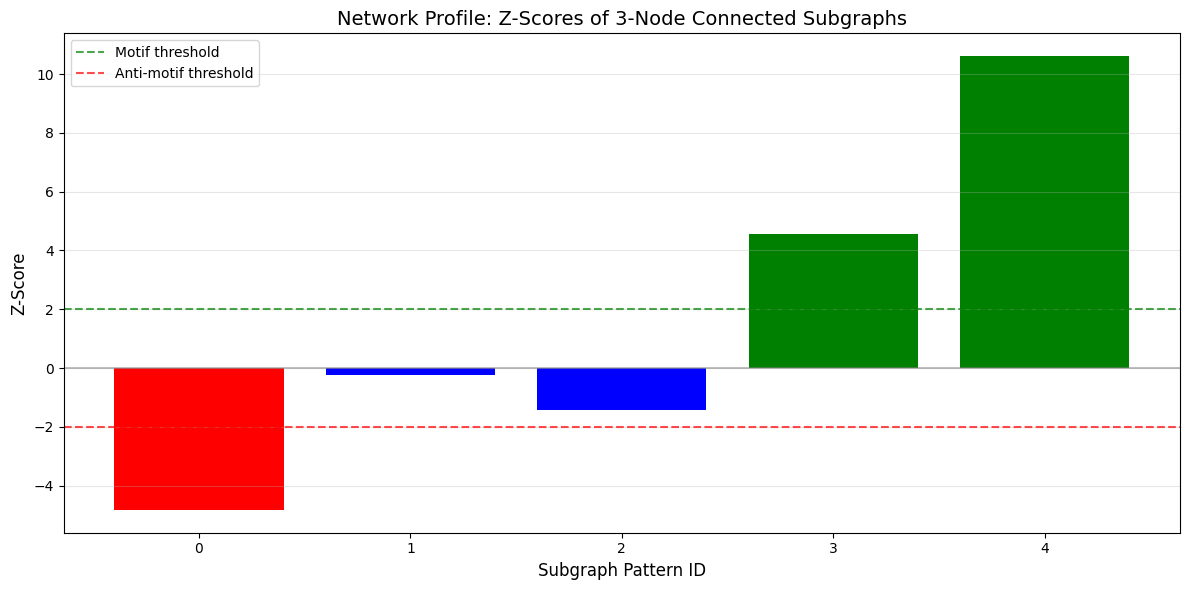

In [46]:

def create_network_profile(z_scores_df, figsize=(10, 6)):
    """
    Create a network profile based on subgraph frequencies.
    
    Parameters:
    -----------
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    figsize : tuple
        Figure size
    """
    # Sort by pattern ID
    df_sorted = z_scores_df.sort_values('Pattern ID')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract data
    pattern_ids = df_sorted['Pattern ID']
    z_scores = df_sorted['Z-Score']
    
    # Determine colors based on Z-scores
    colors = [
        'green' if z > 2.0 else 'red' if z < -2.0 else 'blue'
        for z in z_scores
    ]
    
    # Create bar plot
    bars = ax.bar(pattern_ids, z_scores, color=colors)
    
    # Add reference lines
    ax.axhline(y=2.0, color='green', linestyle='--', alpha=0.7, label='Motif threshold')
    ax.axhline(y=-2.0, color='red', linestyle='--', alpha=0.7, label='Anti-motif threshold')
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Add labels
    ax.set_xlabel('Subgraph Pattern ID', fontsize=12)
    ax.set_ylabel('Z-Score', fontsize=12)
    ax.set_title('Network Profile: Z-Scores of 3-Node Connected Subgraphs', fontsize=14)
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    plt.savefig("network_profile.png", dpi=300)
    plt.show()

# Create a network profile
create_network_profile(z_scores_df, figsize=(12, 6))

## 8: Comparison with Different Random Network Models


Comparing different random network models...

Analyzing with configuration random model:


Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

  Found 2 motifs and 1 anti-motifs

Analyzing with edge_swap random model:


Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

  Found 2 motifs and 2 anti-motifs

Top patterns by Z-score in each model:
   Pattern ID  configuration Z-Score  edge_swap Z-Score
0           0              -5.852212          -6.110026
1           1              -0.203548          -6.913752
2           2              -0.427770          -1.732051
3           3               5.204138           2.991199
4           4               9.441533           7.975746


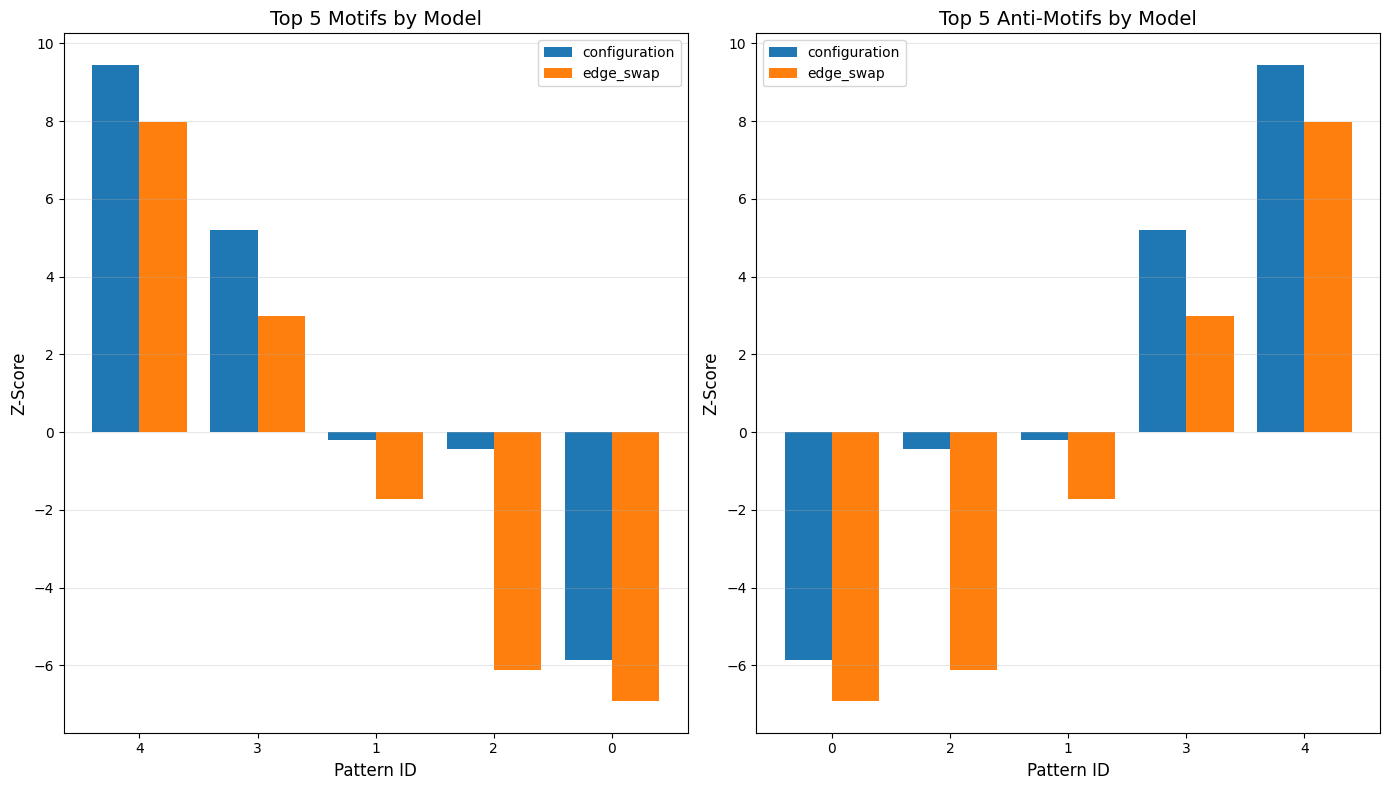


Agreement on motifs:
  configuration vs edge_swap: Jaccard index = 1.00 (overlap 2 out of 2 and 2 motifs)

Agreement on anti-motifs:
  configuration vs edge_swap: Jaccard index = 0.50 (overlap 1 out of 1 and 2 anti-motifs)


In [49]:
def compare_random_models(G, unique_subgraphs, max_samples=5000):
    """
    Compare motif detection using different random network models.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    max_samples : int
        Maximum number of triads to sample per graph
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with Z-scores from different random models
    dict
        Dictionary of all Z-score DataFrames by model
    """
    # Define random models to compare
    random_models = ['configuration', 'edge_swap']
    
    # Store Z-scores for each model
    all_z_scores = {}
    
    # Run analysis for each model
    for model in random_models:
        print(f"\nAnalyzing with {model} random model:")
        z_scores_df_model = compute_z_scores(
            G, 
            unique_subgraphs, 
            num_random=10,  # For demonstration
            random_model=model,
        )
        
        # Identify motifs and anti-motifs
        motifs_model, anti_motifs_model = identify_motifs(z_scores_df_model, threshold=2.0)
        print(f"  Found {len(motifs_model)} motifs and {len(anti_motifs_model)} anti-motifs")
        
        # Store results
        all_z_scores[model] = z_scores_df_model
    
    # Create comparison DataFrame
    comparison_data = []
    for pattern_id in range(len(unique_subgraphs)):
        row = {'Pattern ID': pattern_id}
        for model in random_models:
            model_df = all_z_scores[model]
            if pattern_id in model_df['Pattern ID'].values:
                z_score = model_df[model_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
                row[f'{model} Z-Score'] = z_score
            else:
                row[f'{model} Z-Score'] = 0
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df, all_z_scores


def visualize_model_comparison(comparison_df, top_k=5, figsize=(14, 8)):
    """
    Visualize Z-scores from different random models.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame with Z-scores from different models
    top_k : int
        Number of top motifs to display
    figsize : tuple
        Figure size
    """
    # Get list of models from column names
    models = [col.replace(' Z-Score', '') for col in comparison_df.columns if 'Z-Score' in col]
    
    # Create figure with two subplots (motifs on the left, anti-motifs on the right)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot top k motifs (highest positive Z-scores)
    for model in models:
        col = f'{model} Z-Score'
        top_motifs = comparison_df.sort_values(col, ascending=False).head(top_k)
        
        x = np.arange(len(top_motifs))
        width = 0.8 / len(models)
        offset = width * models.index(model) - width * (len(models) - 1) / 2
        
        ax1.bar(x + offset, top_motifs[col], width, label=model)
        
        # Only set x-ticks for the first model
        if models.index(model) == 0:
            ax1.set_xticks(x)
            ax1.set_xticklabels(top_motifs['Pattern ID'])
    
    ax1.set_xlabel('Pattern ID', fontsize=12)
    ax1.set_ylabel('Z-Score', fontsize=12)
    ax1.set_title(f'Top {top_k} Motifs by Model', fontsize=14)
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Plot top k anti-motifs (lowest negative Z-scores)
    for model in models:
        col = f'{model} Z-Score'
        top_anti_motifs = comparison_df.sort_values(col).head(top_k)
        
        x = np.arange(len(top_anti_motifs))
        width = 0.8 / len(models)
        offset = width * models.index(model) - width * (len(models) - 1) / 2
        
        ax2.bar(x + offset, top_anti_motifs[col], width, label=model)
        
        if models.index(model) == 0:
            ax2.set_xticks(x)
            ax2.set_xticklabels(top_anti_motifs['Pattern ID'])
    
    ax2.set_xlabel('Pattern ID', fontsize=12)
    ax2.set_ylabel('Z-Score', fontsize=12)
    ax2.set_title(f'Top {top_k} Anti-Motifs by Model', fontsize=14)
    ax2.legend()
    ax2.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=300)
    plt.show()


def analyze_model_agreement(comparison_df, threshold=2.0):
    """
    Analyze agreement between random models on motif detection.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame with Z-scores from different models
    threshold : float
        Z-score threshold for significance
    
    Returns:
    --------
    dict
        Dictionary with agreement statistics
    """
    models = [col.replace(' Z-Score', '') for col in comparison_df.columns if 'Z-Score' in col]
    
    # Initialize counters
    motifs_by_model = {}
    anti_motifs_by_model = {}
    
    for model in models:
        col = f'{model} Z-Score'
        motifs_by_model[model] = set(comparison_df[comparison_df[col] > threshold]['Pattern ID'])
        anti_motifs_by_model[model] = set(comparison_df[comparison_df[col] < -threshold]['Pattern ID'])
    
    agreement_stats = {'motifs': {}, 'anti_motifs': {}}
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i >= j:
                continue
            
            # Motifs agreement
            motifs1 = motifs_by_model[model1]
            motifs2 = motifs_by_model[model2]
            intersection = motifs1.intersection(motifs2)
            union = motifs1.union(motifs2)
            jaccard = len(intersection) / len(union) if union else 1.0
            
            agreement_stats['motifs'][f'{model1} vs {model2}'] = {
                'model1_count': len(motifs1),
                'model2_count': len(motifs2),
                'overlap': len(intersection),
                'jaccard_index': jaccard
            }
            
            # Anti-motifs agreement
            anti_motifs1 = anti_motifs_by_model[model1]
            anti_motifs2 = anti_motifs_by_model[model2]
            intersection = anti_motifs1.intersection(anti_motifs2)
            union = anti_motifs1.union(anti_motifs2)
            jaccard = len(intersection) / len(union) if union else 1.0
            
            agreement_stats['anti_motifs'][f'{model1} vs {model2}'] = {
                'model1_count': len(anti_motifs1),
                'model2_count': len(anti_motifs2),
                'overlap': len(intersection),
                'jaccard_index': jaccard
            }
    
    return agreement_stats


# Example: Compare models (re-run or reduce max_samples for speed)
print("\nComparing different random network models...")
comparison_df, all_z_scores = compare_random_models(G, unique_subgraphs)
print("\nTop patterns by Z-score in each model:")
print(comparison_df.head(10))

# Visualize the comparison
visualize_model_comparison(comparison_df, top_k=5)

# Analyze agreement
agreement_stats = analyze_model_agreement(comparison_df)
print("\nAgreement on motifs:")
for comparison, stats in agreement_stats['motifs'].items():
    print(f"  {comparison}: Jaccard index = {stats['jaccard_index']:.2f} "
          f"(overlap {stats['overlap']} out of {stats['model1_count']} "
          f"and {stats['model2_count']} motifs)")

print("\nAgreement on anti-motifs:")
for comparison, stats in agreement_stats['anti_motifs'].items():
    print(f"  {comparison}: Jaccard index = {stats['jaccard_index']:.2f} "
          f"(overlap {stats['overlap']} out of {stats['model1_count']} "
          f"and {stats['model2_count']} anti-motifs)")

## 9. Conclusion and Final Analysis

In [50]:
def generate_summary_report(G, unique_subgraphs, z_scores_df, motifs, anti_motifs):
    """
    Generate a summary report of the network motif analysis.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The analyzed graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    
    Returns:
    --------
    str
        Summary report text
    """
    # Network statistics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Subgraph statistics
    n_unique_subgraphs = len(unique_subgraphs)
    n_observed_subgraphs = sum(z_scores_df['Real Count'])
    
    # Prepare report
    report = f"""
    # Network Motif Analysis Summary Report
    
    ## Network Statistics
    - Network type: Directed graph
    - Number of nodes: {n_nodes}
    - Number of edges: {n_edges}
    - Network density: {density:.6f}
    
    ## Subgraph Analysis
    - Number of unique 3-node connected subgraph patterns: {n_unique_subgraphs}
    - Total subgraphs observed in the network: {n_observed_subgraphs:.0f}
    - Number of statistically significant motifs (Z > 2.0): {len(motifs)}
    - Number of statistically significant anti-motifs (Z < -2.0): {len(anti_motifs)}
    
    ## Top Motifs (Over-represented Subgraphs)
    """
    
    if len(motifs) > 0:
        for i, pattern_id in enumerate(motifs[:5]):  # Show top 5
            z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
            real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
            expected = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
            
            report += f"""
    {i+1}. Pattern ID {pattern_id}:
       - Z-score: {z_score:.2f}
       - Observed count: {real_count} (vs. expected {expected:.2f})
       - Ratio: {real_count/expected:.2f}x more frequent than expected by chance
            """
    else:
        report += "    No statistically significant motifs found.\n"
    
    report += """
    ## Top Anti-Motifs (Under-represented Subgraphs)
    """
    
    if len(anti_motifs) > 0:
        for i, pattern_id in enumerate(anti_motifs[:5]):  # Show top 5
            z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
            real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
            expected = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
            
            report += f"""
    {i+1}. Pattern ID {pattern_id}:
       - Z-score: {z_score:.2f}
       - Observed count: {real_count} (vs. expected {expected:.2f})
       - Ratio: {real_count/expected:.2f}x less frequent than expected by chance
            """
    else:
        report += "    No statistically significant anti-motifs found.\n"
    
    report += """
    ## Conclusions
    
    1. **Structural Organization**: The network shows clear evidence of non-random organization at the local level. 
       Specific 3-node patterns appear more or less frequently than chance expectations.
    
    2. **Citation Patterns (if this is a citation network)**: Over-represented motifs can indicate 
       characteristic citation behaviors (hierarchical, reciprocal, or cyclical). 
       Under-represented subgraphs may reflect disfavored structures.
    
    3. **Random Models**: Results depend on the random model used (configuration vs. edge-swap). 
       The edge-swap model preserves in/out degree but can break certain structural correlations.
    
    4. **Functional Significance**: Over-represented motifs (motifs) often provide functional advantages (robustness, 
       efficient information flow), while anti-motifs might be inefficient or destabilizing patterns.
    """
    
    return report


# Generate summary report
summary_report = generate_summary_report(G, unique_subgraphs, z_scores_df, motifs, anti_motifs)
print(summary_report)

# Save report to file
with open('network_motif_analysis_report.md', 'w') as f:
    f.write(summary_report)

print("\nAnalysis complete! Results saved to 'network_motif_analysis_report.md'")


    # Network Motif Analysis Summary Report
    
    ## Network Statistics
    - Network type: Directed graph
    - Number of nodes: 312
    - Number of edges: 817
    - Network density: 0.008420
    
    ## Subgraph Analysis
    - Number of unique 3-node connected subgraph patterns: 5
    - Total subgraphs observed in the network: 4783
    - Number of statistically significant motifs (Z > 2.0): 2
    - Number of statistically significant anti-motifs (Z < -2.0): 1
    
    ## Top Motifs (Over-represented Subgraphs)
    
    1. Pattern ID 4:
       - Z-score: 10.61
       - Observed count: 43 (vs. expected 4.10)
       - Ratio: 10.49x more frequent than expected by chance
            
    2. Pattern ID 3:
       - Z-score: 4.57
       - Observed count: 169 (vs. expected 59.60)
       - Ratio: 2.84x more frequent than expected by chance
            
    ## Top Anti-Motifs (Under-represented Subgraphs)
    
    1. Pattern ID 0:
       - Z-score: -4.83
       - Observed count: 1582 (vs. e